This is the pracctice 1 session of debiasing Facial Recognitation

In [12]:
#1 Imports
import os
import random
from pathlib import Path
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim


import mitdeeplearning as mdl
import tqdm as tqdm

In [2]:
# 2 Dataset Download
CACHE_DIR = Path.cwd() /".cache"/"mitdeeplearning"
CACHE_DIR.mkdir (parents= True, exist_ok= True)

path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

#Check to avoid re-downloading
if path_to_training_data.is_file():
    print("Data already exists")
else:
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url,path_to_training_data)
    print("Dowloading data to: {path_to_training_data} ")



Data already exists


In [3]:
# 3A. DataLoader

channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data,channels_last=channels_last)

images, labels = loader.get_batch(100)


Opening d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


In [5]:
#3B Checking data size and dimensions
print(f"Datatype of image {images.dtype} and label: {labels.dtype}")

dataset_size = loader.get_train_size()
print(f"Size of training dataset: {dataset_size}")

B,C,H,W = images.shape
print(f"Bach_size:{B}, Channels: {C}, Height:{H}, Width:{W}")


Datatype of image float32 and label: float32
Size of training dataset: 109914
Bach_size:100, Channels: 3, Height:64, Width:64


In [6]:
print(f"Shape of Labels: {labels.shape} Shows that it is a {labels.ndim}-D Array having Rows: {labels.shape[0]} and Columns: {labels.shape[1]}") 

face_lab = np.where(labels==1) # It will return the array in tuple form
faces = face_lab[0] #slelecting the first element of the array

not_face = np.where(labels==0)
no_faces = not_face[0]
print(f"Faces (Where label =1) : {face_lab}") # it prints a tupal of arrays

print(f"Selecting First array (Faces): {faces}") # Printing the first element of the array
print(f"Selecting 2nd Array (non-faces):{no_faces} ") # Printing the 2nd element.


Shape of Labels: (100, 1) Shows that it is a 2-D Array having Rows: 100 and Columns: 1
Faces (Where label =1) : (array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))
Selecting First array (Faces): [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Selecting 2nd Array (non-faces):[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] 


# 4 Display of Dataset

In [7]:
def show_images(idx_face=0, idx_notface = 0):
    face_img = images[np.where(labels==1)[0]].transpose(0,2,3,1)
    notface_img = images[np.where(labels==0)[0]].transpose(0,2,3,1)

    plt.figure(figsize=(5,5))
    
    plt.subplot(1,2,1)
    plt.imshow(face_img[idx_face])
    plt.title("faces")
    plt.grid(False)
    
    plt.subplot(1,2,2)
    plt.imshow(notface_img[idx_notface])
    plt.title("Not Face")

    plt.show()
    

widgets.interact(show_images, idx_face=(0,49), idx_notface=(0,49))



interactive(children=(IntSlider(value=0, description='idx_face', max=49), IntSlider(value=0, description='idx_…

<function __main__.show_images(idx_face=0, idx_notface=0)>

# CNN for Facial Detection


# 🧠 Convolution Output Size Calculations

We’ll use the standard 2D convolution formula for output dimensions:

$
\text{Output Size} = \left\lfloor \frac{\text{Input Size} + 2 \times \text{Padding} - \text{Kernel Size}}{\text{Stride}} \right\rfloor + 1
$

---

### 🔸 Layer 1

**Input:** 64 × 64  
**Kernel size:** 5  
**Stride:** 2  
**Padding:** 2  

$
\text{Output} = \left\lfloor \frac{64 + 2 \times 2 - 5}{2} \right\rfloor + 1 = \left\lfloor \frac{63}{2} \right\rfloor + 1 = \left\lfloor 31.5 \right\rfloor + 1 = 32
$

✅ **Output:** 32 × 32

---

### 🔸 Layer 2

**Input:** 32 × 32  
**Kernel size:** 5  
**Stride:** 2  
**Padding:** 2  

$
\text{Output} = \left\lfloor \frac{32 + 2 \times 2 - 5}{2} \right\rfloor + 1 = \left\lfloor \frac{31}{2} \right\rfloor + 1 = \left\lfloor 15.5 \right\rfloor + 1 = 16
$

✅ **Output:** 16 × 16

---

### 🔸 Layer 3

**Input:** 16 × 16  
**Kernel size:** 3  
**Stride:** 2  
**Padding:** 1  

$
\text{Output} = \left\lfloor \frac{16 + 2 \times 1 - 3}{2} \right\rfloor + 1 = \left\lfloor \frac{15}{2} \right\rfloor + 1 = \left\lfloor 7.5 \right\rfloor + 1 = 8
$

✅ **Output:** 8 × 8

---

### 🔸 Layer 4

**Input:** 8 × 8  
**Kernel size:** 3  
**Stride:** 2  
**Padding:** 1  

$
\text{Output} = \left\lfloor \frac{8 + 2 \times 1 - 3}{2} \right\rfloor + 1 = \left\lfloor \frac{7}{2} \right\rfloor + 1 = \left\lfloor 3.5 \right\rfloor + 1 = 4
$

✅ **Output:** 4 × 4

---

### 🔹 Flattened Size Before Linear Layer

From the last feature map:

- **Channels:** 6 × n_filters = 6 × 12 = 72  
- **Height:** 4  
- **Width:** 4  

$
\text{Flattened Size} = 72 \times 4 \times 4 = 1152
$

✅ **Final flattened vector:** 1152-dimensional





In [8]:
# 4 Define CNN
n_filters = 12
in_channels = images.shape[1]

def make_standard_classifier(n_outputs):
    class ConvBlock(nn.Module):
        def __init__(self,in_channels,out_channels,kernel_size,stride,padding=0):
            super(). __init__()
            self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
            self.relu = nn.ReLU(inplace=True)
            self.bn = nn.BatchNorm2d(out_channels)
        
        def forward(self,x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)

            return x
        
    model = nn.Sequential(
        ConvBlock(in_channels,n_filters,kernel_size = 5, padding = 2,stride = 2),
        ConvBlock(n_filters, 2* n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters,kernel_size=3, stride =2,padding=1),
        ConvBlock(4*n_filters,6*n_filters, kernel_size=3, stride=2, padding=1),
        # Based on the calculation shown abvoe 4*4 * 6 *12 (where 12= n_filters)
        nn.Flatten(),
        nn.Linear(4*4*6*n_filters ,512),
        nn.ReLU(inplace=True),
        nn.Linear(512,n_outputs),
        )
    return model.to('cuda')

# call the function to inistantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier) 


Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

## Parameters Setting

In [10]:
#5 Setting Parameters 
params = dict ( 
    batch_size=32,
    num_epochs = 2,
    learning_rate = 5e-4,
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(standard_classifier.parameters(),lr = params['learning_rate'])

loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')

 ## 1. nn.CrossEntropyLoss()
✅ Use for:
Multi-class classification (e.g., 10 classes like MNIST)

🔢 Inputs:
input: raw logits (shape [B, C], where C is the number of classes)

target: integer class labels (shape [B], each value is 0 to C-1)

🧠 Internally:
It does two things for you:

Applies F.log_softmax() to the logits

Computes negative log likelihood loss

So you don’t need to apply softmax yourself!

✅ Example:
`
logits = model(x)              # shape [B, C]
loss = nn.CrossEntropyLoss()(logits, labels)  # labels: [B] integers
`
## 2. nn.BCELoss()
✅ Use for:
Binary classification or multi-label classification (each class is independent)

🔢 Inputs:
input: probabilities between 0 and 1 (after applying sigmoid)

target: floats in [0, 1] (shape [B] or [B, 1])

⚠️ Caution:
You must apply sigmoid() to the model output before using this loss.

✅ Example:
`logits = model(x)
probs = torch.sigmoid(logits)
loss = nn.BCELoss()(probs, targets)  # targets: [B] or [B, 1]`
## 3. nn.BCEWithLogitsLoss()
✅ Use for:
Same as BCELoss, but more numerically stable.

🔢 Inputs:
input: raw logits (no sigmoid)

target: floats in [0, 1] (same as BCELoss)

🧠 Internally:
Applies sigmoid + BCELoss in one step using a more stable formulation.

✅ Preferred over BCELoss in almost all cases!

✅ Example:
`
logits = model(x)

loss = nn.BCEWithLogitsLoss()(logits, targets)  # targets: [B] or [B, 1]

🧾 Summary Table

Loss Function	For	Input to Loss	Target Type	Applies Sigmoid/Softmax?

CrossEntropyLoss	Multi-class	Logits [B, C]	Class indices [B]	✅ Softmax (internal)

BCELoss	Binary / Multi-label	Probabilities [B]	0/1 floats [B]	❌ You apply sigmoid

BCEWithLogitsLoss	Binary / Multi-label	Logits [B]	0/1 floats [B]	✅ Sigmoid (internal)
`


# ⚠️ Common Mistake:
Using BCELoss without sigmoid, or using BCEWithLogitsLoss with sigmoid applied manually — leads to incorrect gradients!


## 📘 Summary: Mathematical Nature of Key DL Functions

| Function | Type | Mathematical Definition | Notes |
|----------|------|--------------------------|-------|
| **Softmax** | Activation (multi-class) | $ \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} $ | Outputs class probabilities that sum to 1 |
| **Sigmoid** | Activation (binary/multi-label) | $ \sigma(x) = \frac{1}{1 + e^{-x}} $ | S-shaped curve, outputs between 0 and 1 |
| **ReLU** | Activation (hidden layers) | $ \text{ReLU}(x) = \max(0, x) $ | Keeps positives, zeros out negatives |
| **Adam** | Optimizer | $ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t  \\  v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2  \\  \theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $ | Adaptive learning rate optimizer |


## Lets Train the Dragon (CNN)!

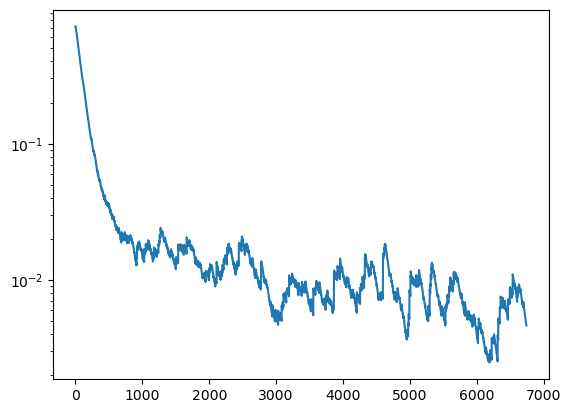

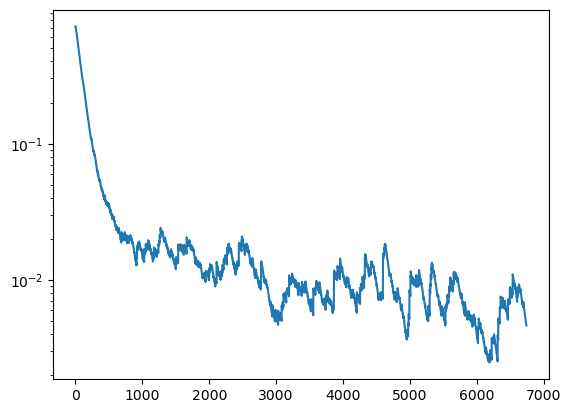

In [20]:
# 6 Training 

if hasattr(tqdm, '._instances'):
    tqdm._instances.clear()
    
standard_classifier.train()

def standard_train_step(x,y):
    x = torch.from_numpy(x).float().to('cuda')
    y = torch.from_numpy(y).float().to('cuda')

    #Clear the gradient
    optimizer.zero_grad()

    #feed the images
    logits = standard_classifier(x)

    # Compute the loss
    loss = loss_fn(logits,y)

    # backward propogation
    loss.backward()
    optimizer.step()
    return loss 

# Training Loop
for epoch in range(params['num_epochs']):
    for idx in (range (loader.get_train_size() // params['batch_size'])):
        # grab a batch and propogate through the network
        x,y = loader.get_batch(params['batch_size'])
        loss = standard_train_step(x,y)
        loss_value = loss.detach().cpu().numpy()

        #Record the loss and plot
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

